<h1>HW4 - Attention and Transformers- Practical Q1</h1>
<h3><font color=yellow>Total Points: 100</font></h3>





---


<h3>Masked language modeling is a technique used in natural language processing to train language models.</h3>
<h3>It originated as a way to teach models contextual understanding and the ability to fill in missing pieces of information within a sentence. </h3>
<h3>The concept involves masking certain words in a sentence and tasking the model with predicting what those masked words should be, based on the context provided by the surrounding words.</h3>


---



<h2>In this assignment you are going to implement and train a Masked Language Model in two settings:</h2>

1.   In the first part you will implement the mlm in PyTorch from scratch
2.   In the second part you will use HuggingFace library to train a RoBERTa MLM using a trainer.


---




<h3><font color=yellow>Notes:</font></h3>


*   The model architecture includes only **Transformer Encoder** layers (from [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper).
*   It is like a BERT model, the only difference is that we won't have the "Next Sentence Prediction" part, in other words the model will be trained only to predict the masked tokens.
*   Remember to save the RoBERTa model in the second part of assignment (trained with HuggingFace lib.), you'll be needing it for the next practical assignment (POS Tagging).
*   Write the code only in the specified parts.
*   If you have any questions, ask your question in Quera.

<font color=greeen>Good Luck!</font>


---




# Imports and Installations

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture

!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install huggingface_hub
!pip install tokenizers

In [4]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import tokenizers
from huggingface_hub import notebook_login

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 1-MLM Implementation with PyTorch From Scratch: <font color=yellow>Total Points:70</font>

## 1-1-Data Preprocessing

In [17]:
#load dataset file and clean it
with open('/content/Parsi_Mianeh_Corpus.txt', 'r') as f:
  corpus = f.read()
corpus = re.sub('٭', '', corpus)
corpus = re.sub('\xa0', '', corpus)
corpus = re.sub('#', '', corpus)

In [18]:
#train tokenizer from scratch with byte pair level
spl_tokens = ['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
temp_post_processor = tokenizers.processors.TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", spl_tokens.index("[CLS]")),
        ("[SEP]", spl_tokens.index("[SEP]")),
    ],
)

tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE(unk_token = spl_tokens[0], mask_token=spl_tokens[2]))
tokenizer_trainer = tokenizers.trainers.BpeTrainer(special_tokens = spl_tokens)
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tokenizer.post_processor=temp_post_processor

paths = ["Parsi_Mianeh_Corpus.txt"]
tokenizer.train(paths, tokenizer_trainer)
tokenizer.save('tokenizer.json')

In [19]:
#get vocab size
vocab_size = tokenizer.get_vocab_size()
print(vocab_size)

6881


<h4>You  need a token with <font color=greeen>WRITE</font> permission</h4>

In [20]:
#logging in to hugging face
notebook_login()

In [22]:
#saved fast tokenizer to file and convert it to roberta tokenizer
fast_tokenizer = transformers.PreTrainedTokenizerFast(tokenizer_file='tokenizer.json')
fast_tokenizer.save_pretrained('fast_tokenizer')

tokenizer = transformers.RobertaTokenizerFast.from_pretrained('fast_tokenizer')
tokenizer.pad_token_id = 0
tokenizer.cls_token_id = 1
tokenizer.sep_token_id = 2
tokenizer.mask_token_id = 3
tokenizer.unk_token_id = 4

your_hugging_face_id="Amir01"
tokenizer.save_pretrained(f'{your_hugging_face_id}/parsig_tokenizer', push_to_hub=True)
tokenizer.save_pretrained('tokenizer')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'RobertaTokenizerFast'.


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [23]:
class Custom_Dataset(Dataset):
    def __init__(self, tokenizer, data, max_length):
        self.tokenizer = tokenizer
        self.corpus = data
        self.corpus_lines = len(data)
        self.max_length = max_length
        self.preprocessed_data=None

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, index):
        return self.preprocessed_data[index]


    def random_word(self, token_ids):

        # remove cls and sep token
        token_ids=token_ids[1:-1]
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token_id in enumerate(token_ids):
            prob = random.random()

            if prob < 0.15:
              prob /= 0.15
              # 80% chance change token to mask token
              if prob < 0.8:
                  output.append(self.tokenizer.vocab['[MASK]'])

              # 10% chance change token to random token
              elif prob < 0.9:
                  output.append(random.randrange(self.tokenizer.vocab_size))

              # 10% chance change token to current token
              else:
                  output.append(token_id)
              output_label.append(token_id)
            else:
              output.append(token_id)
              output_label.append(-100)


        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_corpus_line(self, index):
        return self.corpus[index]


    def preprocess_function(self):
        preprocessed_data=[]

        for i in tqdm(range(self.corpus_lines)):
            # get sample at index
          data = self.get_corpus_line(i)

          # Step 2: replace 15% of tokens randomly
          text_token_ids, text_labels = self.random_word(data['input_ids'])

          # Step 3: Adding CLS and SEP tokens to the start and end of sentences
          input_ids = [self.tokenizer.vocab['[CLS]']] + text_token_ids + [self.tokenizer.vocab['[SEP]']]
          labels = [-100] + text_labels + [-100]

          # Step 4: Truncate at max_length
          input_ids = (input_ids)[:self.max_length]
          segment_ids = ([1 for _ in range(len(input_ids))])[:self.max_length]
          labels = (labels)[:self.max_length]

          # Step 5: pad ids and labels
          padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.max_length - len(input_ids))]
          label_padding = [-100 for _ in range(self.max_length - len(input_ids))]
          input_ids.extend(padding), segment_ids.extend(padding), labels.extend(label_padding)

          output = {"input_ids": input_ids,
                    "labels": labels,
                    "segment_ids": segment_ids}

          output={key: torch.tensor(value) for key, value in output.items()}
          preprocessed_data.append(output)

        self.preprocessed_data=preprocessed_data
        return preprocessed_data

Loading Dataset

In [24]:
with open('Parsi_Mianeh_Corpus.txt', 'r') as f:
  text = f.read()
sentences = text.split('\n')[:-1]
corpus_df=pd.DataFrame(data=sentences, columns=["text"])
corpus_df

,text
0,ud baγōbaxt ān ī did-iz baxšēnd
1,ud ka mīrēnd ahlaw hēnd
2,ud ōy ī pēm-xwarišn mardōm tan-drusttar ud zōr...
3,kū pādixšāyān rāy tis-ē ham-pursagīh ī abāg dā...
4,pad ǰōrdā ham-dādestān būd hēnd kū ān and gyāg...
...,...
3404,ud pad wīst-sālag hāxtēd kawīg ī kundā pus
3405,čē guft ēstēd
3406,čē ōy ī bēš-burdār rāmišn ī gētīg ud mēnōg wan...
3407,ud šašom kē pad čašm ī yazadān ud uzwān ī wehā...


In [25]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({'train': Dataset.from_pandas(corpus_df)})
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3409
    })
})

In [26]:
max_input_length = 512
max_target_length = 64

def tokenize_preprocess_function(examples):
    model_inputs = tokenizer(examples["text"], max_length=max_input_length, truncation=True)
    return model_inputs

tokenized_datasets = dataset.map(tokenize_preprocess_function, batched=False)
tokenized_datasets

Map:   0%|          | 0/3409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 3409
    })
})

Preprocess your dataset once and Save it

In [12]:
MAX_LEN=100

train_dataset = Custom_Dataset(tokenizer, tokenized_datasets['train'], max_length=MAX_LEN)
preprocessed_data=train_dataset.preprocess_function()

In [ ]:
with open('/content/drive/MyDrive/preprocessed_data.pkl', 'wb') as file:
  pickle.dump(preprocessed_data, file)

<font color=yellow>shared link of preprocessed Data</font> </br>
<font color=greeen>add the shortcut to your drive first</font></br>
https://drive.google.com/file/d/1ktCRq0J6QDzrW4T-Obx8m7u6GLU7JTq1/view

In [27]:
MAX_LEN=100
path="/content/drive/MyDrive/preprocessed_data.pkl"
with open(path, 'rb') as file:
    preprocessed_data = pickle.load(file)

print(len(preprocessed_data))

3409


In [28]:
BATCH_SIZE=128

train_loader = DataLoader(preprocessed_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
sample_data = next(iter(train_loader))
sample_data
# print(train_data[random.randrange(len(train_dataset))])

{'input_ids': tensor([[   1,    3,    6,  ...,    0,    0,    0],
         [   1, 1773,  180,  ...,    0,    0,    0],
         [   1,   84, 1008,  ...,    0,    0,    0],
         ...,
         [   1, 5943,   59,  ...,    0,    0,    0],
         [   1, 1785,   86,  ...,    0,    0,    0],
         [   1,   65,  702,  ...,    0,    0,    0]]),
 'labels': tensor([[-100,  767, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         ...,
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100]]),
 'segment_ids': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

## 1-2-Embeddings

Positional Embedding

In [29]:
class PositionalEmbedding(torch.nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, max_len, device="cpu"):
        super(PositionalEmbedding, self).__init__()
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here

        # same size with input matrix (for adding with input matrix)
        self.embedding = torch.zeros(max_len, d_model, device=device)
        self.embedding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.embedding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.embedding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional embedding to consider positional information of words
        #################################################################################
        #                             """ 5 points """
        #################################################################################
        self.embedding = self.embedding.to(device)

    def forward(self, x):
        """
        :params x: (batch_size, max_len)
        :output shape: (batch_size, max_len, d_model)
        """
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.embedding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]

Token Embedding

In [30]:
class Embedding(torch.nn.Module):
    """
    Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of Embedding
    """

    def __init__(self, vocab_size, embed_size, seq_len, dropout=0.1, device="cpu"):
        super().__init__()
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here
        self.tok_emb = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.pos_emb = PositionalEmbedding(embed_size, seq_len, device=device)
        self.seg_emb = torch.nn.Embedding(3, embed_size, padding_idx=0  )
        self.dropout = torch.nn.Dropout(p=dropout)
        self.embed_size = embed_size
        #################################################################################
        #                             """ 5 points """
        #################################################################################

    def forward(self, sequence, segment_id):
        """
        :params sequence: (batch_size, max_len)
        :param segment_id: (batch_size, max_len)
        :output shape: (batch_size, max_len, d_model)
        """
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here
        tok_embed = self.tok_emb(sequence)
        pos_embed = self.pos_emb(sequence)
        seg_embed = self.seg_emb(segment_id)

        x = tok_embed + pos_embed + seg_embed
        #################################################################################
        #                            """ 4 points """
        #################################################################################
        return self.dropout(x)

## 1-3-Attention Module

Multi Head Attention

In [31]:
class ScaledDotProductAttention(torch.nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask, k_dim):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(k_dim)
        scores = scores.masked_fill(attn_mask == True, -1e9) # Fill padding elements with extremely low score
        attn = torch.nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

In [32]:
class MultiHeadedAttention(torch.nn.Module):

    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % heads == 0
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here
        self.n_head = heads
        self.attention = ScaledDotProductAttention()
        self.w_q = torch.nn.Linear(d_model, d_model)
        self.w_k = torch.nn.Linear(d_model, d_model)
        self.w_v = torch.nn.Linear(d_model, d_model)
        self.w_concat = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(p=dropout)
        #################################################################################
        #                             """ 5 points """
        #################################################################################

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

    def forward(self, query, key, value, mask):
        """
        :params query, key, value of shape: (batch_size, max_len, d_model)
        :param mask: pad and non-pad token masks shape: (batch_size, 1, 1, max_words)
        :output shape: (batch_size, max_len, d_model)
        """
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here
        # 1. dot product with weight matrices
        q, k, v = self.w_q(query), self.w_k(key), self.w_v(value)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, attn_mask=mask, k_dim=k.size(-1))

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        #################################################################################
        #                             """ 9 points """
        #################################################################################
        return out

## 1-4-Encoder Module

In [33]:
class PositionwiseFeedForward(torch.nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, middle_dim, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
          # Your Code Here
        self.linear1 = torch.nn.Linear(d_model, middle_dim)
        self.linear2 = torch.nn.Linear(middle_dim, d_model)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout)
        #################################################################################
        #                             """ 4 points """
        #################################################################################

    def forward(self, x):
        """
        :param x: (batch_size, max_len, d_model)
        :output shape: (batch_size, max_len, d_model)
        """
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
          # Your Code Here
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        #################################################################################
        #                             """ 4 points """
        #################################################################################
        return x

In [34]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model=768, heads=12, feed_forward_hidden=768 * 4, dropout=0.1):
        super(EncoderLayer, self).__init__()
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here
        self.attention = MultiHeadedAttention(d_model=d_model, heads=heads)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.dropout1 = torch.nn.Dropout(p=dropout)

        self.ffn = PositionwiseFeedForward(d_model=d_model, middle_dim=feed_forward_hidden, dropout=dropout)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout2 = torch.nn.Dropout(p=dropout)
        #################################################################################
        #                             """ 5 points """
        #################################################################################

    def forward(self, embeddings, mask):
        """:param embeddings: input embeddings (batch_size, max_len, d_model)
           :param mask: pad and non-pad token masks (batch_size, 1, 1, max_len)
           :output shape: (batch_size, max_len, d_model)
        """
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here
        # 1. compute self attention
        x = embeddings
        _x = x
        x = self.attention(query=x, key=x, value=x, mask=mask)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # 3. positionwise feed forward network
        _x = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        #################################################################################
        #                             """ 7 points """
        #################################################################################
        return x

## 1-5-Final model

In [35]:
def get_attn_pad_mask(seq_a, seq_b):
    batch_size, len_a = seq_a.size()
    batch_size, len_b = seq_b.size()
    pad_attn_mask = seq_b.data.eq(0).unsqueeze(1) # one is for masking pad tokens True
    return pad_attn_mask.expand(batch_size, len_a, len_b).unsqueeze(1)  # batch_size x 1 x len_a x len_b

In [36]:
class Masked_Language_Model(torch.nn.Module):
    def __init__(self, vocab_size, seq_len, d_model=768, n_layers=12, heads=12, dropout=0.1, device="cpu"):
        """
        :param vocab_size: vocab_size of total words
        :param seq_len: maximum sequence length
        :param d_model: model hidden size
        :param n_layers: numbers of Encoder Transformer blocks(layers)
        :param heads: number of attention heads
        :param dropout: dropout rate
        """
        super().__init__()
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here
        self.d_model = d_model
        self.embedding = Embedding(vocab_size, d_model, seq_len, dropout, device)
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(d_model, heads, dropout=dropout) for _ in range(n_layers)])
        self.linear = torch.nn.Linear(d_model, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)
        #################################################################################
        #                              """ 7 points """
        #################################################################################


    def forward(self, x, segment_info):
        """:param x: (batch_size, max_len)
           :param segment_info: (batch_size, max_len)
           :output shape: (batch_size, max_len, vocab_size)
        """
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Your Code Here
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        # mask = get_attn_pad_mask(x, x * (1 - segment_info))

        x = self.embedding(x, segment_info)

        for layer in self.encoder_layers:
            x = layer(x, mask)

        x = self.softmax(self.linear(x))
        #################################################################################
        #                              """ 8 points """
        #################################################################################
        return x

## 1-6-Trainer and LR_scheduler

In [37]:
class Learning_Rate_Scheduler():
    '''A simple wrapper class for learning rate scheduling'''
    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [38]:
import torch.nn.functional as F

class Trainer:
    def __init__(
        self,
        model,
        train_dataloader,
        num_epochs,
        test_dataloader=None,
        lr= 1e-4,
        weight_decay=0.08,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader


        """ Defining optimizer and Learning Rate scheduler """
        self.optimizer = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.lr_scheduler = Learning_Rate_Scheduler(
            self.optimizer, self.model.d_model, n_warmup_steps=warmup_steps
            )

        """ Using CrossEntropy Loss function for predicting the masked_token """
        self.criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)

        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))



    def Fit(self, train_loader, num_epochs, path_to_save):

      self.train_losses = []
      lrs=[]

      for epoch in range(num_epochs):
        train_per_epoch_loss=0
        train_data_total = 0

        with tqdm(train_loader, unit="batch") as batches:
          for data in batches:
            batches.set_description(f"Epoch {epoch + 1}")

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            #################################################################################
            #                          COMPLETE THE FOLLOWING SECTION                       #
            #################################################################################
            # 1. forward phase
            # Your Code Here
            output = self.model(data['input_ids'], data['segment_ids'])
            target = data['labels']


            # 2. calculate Loss only for MASKed tokens
            """ Attention! non-masked token ids are set to -100 """
            # Your Code Here
            loss = self.criterion(output.view(-1, output.size(-1)), target.view(-1))

            #################################################################################
            #                                """ 7 points """
            #################################################################################
            # 3. backward and optimization
            self.lr_scheduler.zero_grad()
            loss.backward()
            self.lr_scheduler.step_and_update_lr()

            lrs.append(self.optimizer.param_groups[0]["lr"])
            train_data_total += len(data["labels"])
            train_per_epoch_loss += loss.item()
            batches.set_postfix(train_loss = (train_per_epoch_loss/len(train_loader))) # update loss per batch of data

        self.train_losses.append(train_per_epoch_loss/len(train_loader))

        if epoch%10==0:
          PATH=f"{path_to_save}mlm_{num_epochs}Eps_{epoch}"

          torch.save({
                      'epoch': epoch,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.train_losses[-1],
                      }, PATH)

      self.history={
        'train_losses':self.train_losses,
        'optimizer':self.optimizer,
        'learning_rates':lrs
      }
      return self.history

## 1-7-Training the model

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path_to_save_checkpoints="/content/"

num_epochs = 60
BATCH_SIZE=128
train_loader = DataLoader(preprocessed_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)


model = Masked_Language_Model(
  vocab_size=tokenizer.vocab_size,
  seq_len=MAX_LEN,
  d_model=768,
  n_layers=6,
  heads=12,
  dropout=0.1,
  device=device
)
model=model.to(device)

trainer = Trainer(model, train_loader, num_epochs, lr= 1e-3, weight_decay=0.08, betas=(0.9, 0.999), device=device)
history=trainer.Fit(train_loader, num_epochs, path_to_save_checkpoints)

Total Parameters: 53105633


Epoch 60: 100%|██████████| 27/27 [00:26<00:00,  1.03batch/s, train_loss=6]


Plot Training Loss

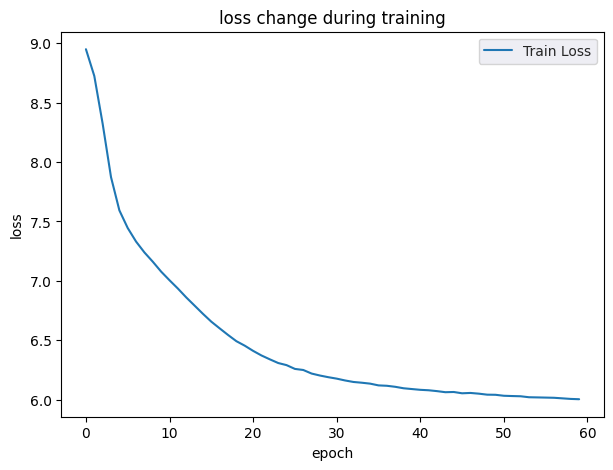

In [40]:
plt.subplots(figsize=(7, 5))
sns.set_style("dark")
sns.lineplot(data=np.asarray(history['train_losses']),label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

# 2-Implement MLM with Hugging_Face: <font color=yellow>Total Points:30</font>

<h3><font color=lightblue>In this part you will train a RoBERTa MLM using Hugging Face library</font></h3>

<h4>you will need a token with <font color=greeen>WRITE</font> permission</h4>

In [5]:
#logging in to hugging face
notebook_login()

## 2-1-Load, Train and Save the Tokenizer on Dataset texts

In [6]:
#load dataset file and clean it
with open('/content/Parsi_Mianeh_Corpus.txt', 'r') as f:
  corpus = f.read()
corpus = re.sub('٭', '', corpus)
corpus = re.sub('\xa0', '', corpus)
corpus = re.sub('#', '', corpus)

In [7]:
#train tokenizer from scratch with byte pair level
spl_tokens = ["[UNK]", "[SEP]", "[MASK]", "[CLS]", "[PAD]"]
temp_post_processor = tokenizers.processors.TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", spl_tokens.index("[CLS]")),
        ("[SEP]", spl_tokens.index("[SEP]")),
    ],
)

tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE(unk_token = spl_tokens[0], mask_token=spl_tokens[2]))
tokenizer_trainer = tokenizers.trainers.BpeTrainer(special_tokens = spl_tokens)
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tokenizer.post_processor=temp_post_processor

paths = ["Parsi_Mianeh_Corpus.txt"]
tokenizer.train(paths, tokenizer_trainer)
tokenizer.save('tokenizer.json')

In [8]:
#get vocab size
vocab_size = tokenizer.get_vocab_size()
print(vocab_size)

6881


In [9]:
#saved fast tokenizer to file and convert it to roberta tokenizer
fast_tokenizer = transformers.PreTrainedTokenizerFast(tokenizer_file='tokenizer.json')
fast_tokenizer.save_pretrained('fast_tokenizer')

tok = transformers.RobertaTokenizerFast.from_pretrained('fast_tokenizer')
tok.unk_token_id = 0
tok.sep_token_id = 1
tok.mask_token_id = 2
tok.cls_token_id = 3
tok.pad_token_id = 4

your_hugging_face_id="Amir01"
tok.save_pretrained(f'{your_hugging_face_id}/parsig_pos', push_to_hub=True)
tok.save_pretrained(f'{your_hugging_face_id}/parsig_tokenizer', push_to_hub=True)
tok.save_pretrained('tokenizer')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'RobertaTokenizerFast'.


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

## 2-2-Data preparation

In [10]:
#define Custom Dataset class for our model
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        # or use the RobertaTokenizer from `transformers` directly.
        self.examples = []
        # For every value in the dataframe
        for example in df.values:
            x=tokenizer.encode_plus(example, max_length = 100, truncation=True, padding=True)
            self.examples += [{"input_ids":x.input_ids, "attention_mask": x.attention_mask}]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        # We’ll pad at the batch level.
        return {key: torch.tensor(value) for key, value in self.examples[i].items()}

In [40]:
#load tokenizer from trained model
tokenizer = transformers.AutoTokenizer.from_pretrained('tokenizer', padding_side='right', max_length=100)

#read files again for train model
with open('Parsi_Mianeh_Corpus.txt', 'r') as f:
  fin_snt = f.read()
fin_snt = fin_snt.split('\n')[:-1]


# Create the train and evaluation dataset
train_data, eval_data = train_test_split(fin_snt, train_size=0.85)
train_df = pd.DataFrame({'text': train_data})
eval_df = pd.DataFrame({'text': eval_data})

train_dataset = CustomDataset(train_df['text'], tokenizer)
eval_dataset = CustomDataset(eval_df['text'], tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 2-3-Define model and its Config

In [41]:
#generate config for train Roberta masked language model
from transformers import RobertaForMaskedLM
from transformers import RobertaConfig

#################################################################################
#                     COMPLETE THE FOLLOWING SECTION                            #
#################################################################################
""" Define appropriate config and instantiate the model  """

config = RobertaConfig()

model = RobertaForMaskedLM(config)
#################################################################################
#                          """ 10 ponits """
#################################################################################

In [42]:
from transformers import DataCollatorForLanguageModeling
#################################################################################
#                     COMPLETE THE FOLLOWING SECTION                            #
#################################################################################
""" Define datacollator for masked language modeling and set the appropriate parameters  """
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm_probability=0.15)
#################################################################################
#                           """ 5 ponits """
#################################################################################

## 2-4-Set training arguments and define a Trainer

In [43]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

#################################################################################
#                     COMPLETE THE FOLLOWING SECTION                            #
#################################################################################
""" Define training arguments and trainer  """
""" Use EarlyStopping CallBack """

NUM_EPOCHS=200
BATCH_SIZE=64
learning_rate=1e-4
checkpoints_output_dir="/content/mlm"


earlyStoping_callBack = EarlyStoppingCallback(
    early_stopping_patience=3
)


training_args = TrainingArguments(
    f"Roberta-finetuned-Parsi-Mianeh-Corpus",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=True,
    evaluation_strategy="steps",
    eval_steps=20,
    logging_steps=20,
    prediction_loss_only=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
)


trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=training_args,
    data_collator=data_collator,
)

#################################################################################
#                         """ 15 ponits """
#################################################################################

## 2-5-Training the model

<h4><font color=hotpink>Perplexity before Training</font></h4>


*   <font color=lightblue>In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. </font>
*   <font color=lightblue>A low perplexity indicates the probability distribution is good at predicting the sample.</font>
*   <font color=lightblue>The perplexity of a language model measures the degree of uncertainty of a LM when it generates a new token, averaged over very long sequences</font>

<font color=lightpink>We will calculate perplexity before and after training, in order to see how well the model is doing:</font>

In [44]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


>>> Perplexity: 55868.21


**Train the model and Save it**

In [45]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss
20,9.861600,9.376146
40,9.200600,9.019770
60,8.825900,8.561954
80,8.552700,8.304963
100,8.123600,8.304769
120,7.991000,8.129773
140,7.929200,7.972017
160,7.759600,7.753357
180,7.645300,7.608751
200,7.547000,7.462473


TrainOutput(global_step=273, training_loss=8.090371659387163, metrics={'train_runtime': 193.407, 'train_samples_per_second': 44.936, 'train_steps_per_second': 1.412, 'total_flos': 333799011464292.0, 'train_loss': 8.090371659387163, 'epoch': 3.0})

In [47]:
path_to_save_model="/content/drive/MyDrive"
trainer.save_model(f"{path_to_save_model}/model.pk")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

events.out.tfevents.1703287767.906200b08092.832.0:   0%|          | 0.00/416 [00:00<?, ?B/s]

events.out.tfevents.1703287966.906200b08092.832.2:   0%|          | 0.00/252 [00:00<?, ?B/s]

Upload 11 LFS files:   0%|          | 0/11 [00:00<?, ?it/s]

events.out.tfevents.1703288190.906200b08092.832.3:   0%|          | 0.00/252 [00:00<?, ?B/s]

events.out.tfevents.1703287881.906200b08092.832.1:   0%|          | 0.00/416 [00:00<?, ?B/s]

events.out.tfevents.1703288213.906200b08092.832.4:   0%|          | 0.00/252 [00:00<?, ?B/s]

events.out.tfevents.1703288463.906200b08092.832.5:   0%|          | 0.00/252 [00:00<?, ?B/s]

events.out.tfevents.1703288483.906200b08092.832.6:   0%|          | 0.00/252 [00:00<?, ?B/s]

events.out.tfevents.1703288607.906200b08092.832.7:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

events.out.tfevents.1703288795.906200b08092.832.8:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

In [48]:
tokenizer.save_pretrained(f'{path_to_save_model}/tokenizer.pk')

('/content/drive/MyDrive/tokenizer.pk/tokenizer_config.json',
 '/content/drive/MyDrive/tokenizer.pk/special_tokens_map.json',
 '/content/drive/MyDrive/tokenizer.pk/vocab.json',
 '/content/drive/MyDrive/tokenizer.pk/merges.txt',
 '/content/drive/MyDrive/tokenizer.pk/added_tokens.json',
 '/content/drive/MyDrive/tokenizer.pk/tokenizer.json')

In [49]:
trainer.push_to_hub()

'https://huggingface.co/Amir01/Roberta-finetuned-Parsi-Mianeh-Corpus/tree/main/'

In [50]:
tokenizer.save_pretrained(f'{your_hugging_face_id}/mlm_tokenizer', push_to_hub=True)

('Amir01/mlm_tokenizer/tokenizer_config.json',
 'Amir01/mlm_tokenizer/special_tokens_map.json',
 'Amir01/mlm_tokenizer/vocab.json',
 'Amir01/mlm_tokenizer/merges.txt',
 'Amir01/mlm_tokenizer/added_tokens.json',
 'Amir01/mlm_tokenizer/tokenizer.json')

<h4><font color=hotpink>Perplexity after Training</font></h4>

In [51]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 1657.33


In [52]:
from transformers import pipeline

model=model.to("cpu")
mask_filler = pipeline('fill-mask', model=model, tokenizer=tokenizer)

masked_query="hamāg-zōhr pus ī wāspuhr ī šāhān [MASK] ī dāmān pahlomtom andar gēhān abāyišnīgtom"
preds=mask_filler(masked_query)

for pred in preds:
    print(f">>> {pred['sequence']}")

>>> hamāg - zōhr pus ī wāspuhr ī šāhān - ī dāmān pahlomtom andar gēhān abāyišnīgtom
>>> hamāg - zōhr pus ī wāspuhr ī šāhān ī ī dāmān pahlomtom andar gēhān abāyišnīgtom
>>> hamāg - zōhr pus ī wāspuhr ī šāhān ud ī dāmān pahlomtom andar gēhān abāyišnīgtom
>>> hamāg - zōhr pus ī wāspuhr ī šāhān pad ī dāmān pahlomtom andar gēhān abāyišnīgtom
>>> hamāg - zōhr pus ī wāspuhr ī šāhān ān ī dāmān pahlomtom andar gēhān abāyišnīgtom
